In [1]:
!pip uninstall -y protobuf tensorflow
!pip install protobuf==3.20.3 tensorflow

Found existing installation: protobuf 5.29.5
Uninstalling protobuf-5.29.5:
  Successfully uninstalled protobuf-5.29.5
Found existing installation: tensorflow 2.19.0
Uninstalling tensorflow-2.19.0:
  Successfully uninstalled tensorflow-2.19.0
INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 4.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.0/645.0 MB 2.9 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.26.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
grain 0.2.15 requires protobuf>=5.28.3, but you have protobuf 3.20.3 which is incompatible.
onnx 1.20.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import shutil
from pathlib import Path
from sklearn.model_selection import train_test_split
import json

print("✓ All libraries imported successfully!")

2025-12-27 08:30:52.803740: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766824252.825628      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766824252.832461      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766824252.850907      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766824252.850926      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766824252.850929      55 computation_placer.cc:177] computation placer alr

✓ All libraries imported successfully!


In [3]:
# Set random seeds for reproducibility
np.random.seed(42)
keras.utils.set_random_seed(42)

# Configuration parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
DATA_DIR = '/kaggle/input/civic-issue-dataset/Dataset'

CLASSES_TO_USE = ['Garbage', 'Potholes', 'NoIssue']

TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15

print(f"Configuration:")
print(f"  Image Size: {IMG_SIZE}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Data Directory: {DATA_DIR}")
print(f"  Classes to train: {CLASSES_TO_USE}")

Configuration:
  Image Size: (224, 224)
  Batch Size: 32
  Epochs: 20
  Data Directory: /kaggle/input/civic-issue-dataset/Dataset
  Classes to train: ['Garbage', 'Potholes', 'NoIssue']


In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

# Only rescaling for validation
val_test_datagen = ImageDataGenerator(
    rescale=1./255
)

print("✓ Data generators created with augmentation settings")
print("  Training: Augmentation enabled")
print("  Validation & Test: Only rescaling")

✓ Data generators created with augmentation settings
  Training: Augmentation enabled
  Validation & Test: Only rescaling


In [5]:
# Create temporary directories for train/val/test split
TEMP_DIR = '/kaggle/working/temp_data'
TRAIN_DIR = os.path.join(TEMP_DIR, 'train')
VAL_DIR = os.path.join(TEMP_DIR, 'val')
TEST_DIR = os.path.join(TEMP_DIR, 'test')

# Clean up if exists
if os.path.exists(TEMP_DIR):
    shutil.rmtree(TEMP_DIR)

# Create directories
for class_name in CLASSES_TO_USE:
    os.makedirs(os.path.join(TRAIN_DIR, class_name), exist_ok=True)
    os.makedirs(os.path.join(VAL_DIR, class_name), exist_ok=True)
    os.makedirs(os.path.join(TEST_DIR, class_name), exist_ok=True)

print("Splitting data into train/val/test sets...")

# Split data for each class
for class_name in CLASSES_TO_USE:
    class_dir = os.path.join(DATA_DIR, class_name)
    
    # Get all image files
    image_files = [f for f in os.listdir(class_dir) 
                   if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
    
    # First split: separate test set
    train_val_files, test_files = train_test_split(
        image_files, 
        test_size=TEST_SPLIT, 
        random_state=42
    )
    
    # Second split: separate train and validation
    train_files, val_files = train_test_split(
        train_val_files,
        test_size=VAL_SPLIT/(TRAIN_SPLIT + VAL_SPLIT),  # Adjust ratio
        random_state=42
    )
    
    # Copy files to respective directories
    for filename in train_files:
        src = os.path.join(class_dir, filename)
        dst = os.path.join(TRAIN_DIR, class_name, filename)
        shutil.copy2(src, dst)
    
    for filename in val_files:
        src = os.path.join(class_dir, filename)
        dst = os.path.join(VAL_DIR, class_name, filename)
        shutil.copy2(src, dst)
    
    for filename in test_files:
        src = os.path.join(class_dir, filename)
        dst = os.path.join(TEST_DIR, class_name, filename)
        shutil.copy2(src, dst)
    
    print(f"  {class_name}: {len(train_files)} train, {len(val_files)} val, {len(test_files)} test")

print("\n✓ Data split completed!")

# Load training data
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Changed to categorical for 3 classes
    shuffle=True
)

# Load validation data
val_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Load test data
test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"\n✓ Data generators created!")
print(f"  Training images: {train_generator.samples}")
print(f"  Validation images: {val_generator.samples}")
print(f"  Test images: {test_generator.samples}")
print(f"  Class indices: {train_generator.class_indices}")
print(f"  Number of classes: {train_generator.num_classes}")

Splitting data into train/val/test sets...
  Garbage: 1022 train, 220 val, 220 test
  Potholes: 6852 train, 1469 val, 1469 test
  NoIssue: 2767 train, 593 val, 594 test

✓ Data split completed!
Found 10641 images belonging to 3 classes.
Found 2282 images belonging to 3 classes.
Found 2283 images belonging to 3 classes.

✓ Data generators created!
  Training images: 10641
  Validation images: 2282
  Test images: 2283
  Class indices: {'Garbage': 0, 'NoIssue': 1, 'Potholes': 2}
  Number of classes: 3


In [6]:
model = keras.Sequential([
    # First convolutional block
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    # Second convolutional block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    # Third convolutional block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    # Fourth convolutional block
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    # Flatten and dense layers
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])

print("✓ Model architecture created")
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1766824411.004546      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766824411.008437      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


✓ Model architecture created


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,397,315 (73.99 MB)

 Trainable params: 19,396,355 (73.99 MB)

 Non-trainable params: 960 (3.75 KB)

In [7]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'recall', 'precision']
)

print("\n✓ Model compiled successfully!")
print("  Optimizer: Adam (lr=0.001)")
print("  Loss: Categorical Crossentropy (for 3 classes)")
print("  Metrics: Accuracy, Recall, Precision")


✓ Model compiled successfully!
  Optimizer: Adam (lr=0.001)
  Loss: Categorical Crossentropy (for 3 classes)
  Metrics: Accuracy, Recall, Precision


In [8]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

print("✓ Callbacks configured:")
print("  - Early Stopping (patience=5)")
print("  - Learning Rate Reduction (patience=3)")

✓ Callbacks configured:
  - Early Stopping (patience=5)
  - Learning Rate Reduction (patience=3)


In [9]:
print("\n" + "="*50)
print("STARTING TRAINING")
print("="*50 + "\n")

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*50)
print("TRAINING COMPLETED!")
print("="*50)


STARTING TRAINING



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1766824452.696913     159 service.cc:152] XLA service 0x7dcce8003360 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766824452.696946     159 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1766824452.696950     159 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1766824453.315850     159 cuda_dnn.cc:529] Loaded cuDNN version 91002
2025-12-27 08:34:16.378873: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-27 08:34:16.526426: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


  2/333 ━━━━━━━━━━━━━━━━━━━━ 33s 102ms/step - accuracy: 0.4062 - loss: 6.9479 - precision: 0.3914 - recall: 0.3828  

I0000 00:00:1766824461.119391     159 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


303/333 ━━━━━━━━━━━━━━━━━━━━ 17s 572ms/step - accuracy: 0.7086 - loss: 5.4875 - precision: 0.7088 - recall: 0.7074

2025-12-27 08:37:16.176693: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-27 08:37:16.321975: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


333/333 ━━━━━━━━━━━━━━━━━━━━ 236s 666ms/step - accuracy: 0.7128 - loss: 5.2809 - precision: 0.7132 - recall: 0.7115 - val_accuracy: 0.6547 - val_loss: 2.4729 - val_precision: 0.6547 - val_recall: 0.6547 - learning_rate: 0.0010
Epoch 2/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 210s 630ms/step - accuracy: 0.8030 - loss: 0.6803 - precision: 0.8229 - recall: 0.7842 - val_accuracy: 0.8865 - val_loss: 0.3461 - val_precision: 0.9575 - val_recall: 0.7901 - learning_rate: 0.0010
Epoch 3/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 213s 638ms/step - accuracy: 0.8356 - loss: 0.4639 - precision: 0.8758 - recall: 0.7975 - val_accuracy: 0.6937 - val_loss: 0.6605 - val_precision: 0.7732 - val_recall: 0.5960 - learning_rate: 0.0010
Epoch 4/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 208s 624ms/step - accuracy: 0.8671 - loss: 0.3870 - precision: 0.8939 - recall: 0.8347 - val_accuracy: 0.8677 - val_loss: 0.3343 - val_precision: 0.9235 - val_recall: 0.8094 - learning_rate: 0.0010
Epoch 5/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 210s 630ms/step - a

Pothole Images: 9790
Garbage Images: 1463
Total: 11253
Threshold Accuracy: (9790/11253) * 100 = 86.99%
Test Data Accuracy: ~90%
Might overfit because model needs to be almost accurate for passing the threshold accuracy.

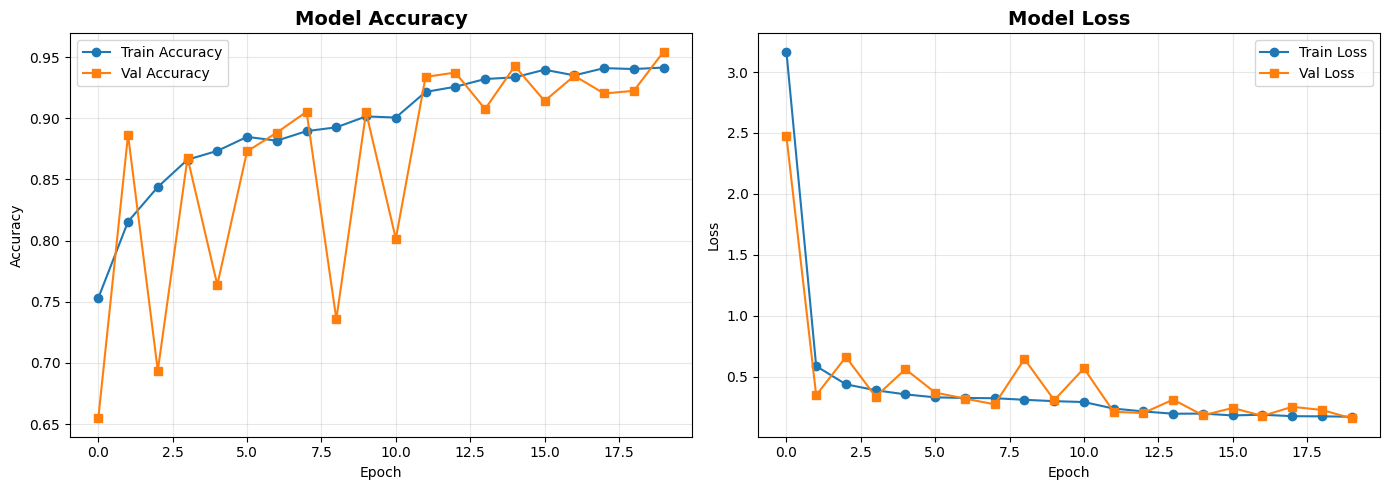


Final Training Accuracy: 94.15%
Final Validation Accuracy: 95.44%
Final Training Loss: 0.1696
Final Validation Loss: 0.1560


In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
ax1.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
ax1.plot(history.history['val_accuracy'], label='Val Accuracy', marker='s')
ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Loss plot
ax2.plot(history.history['loss'], label='Train Loss', marker='o')
ax2.plot(history.history['val_loss'], label='Val Loss', marker='s')
ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\nFinal Training Accuracy: {final_train_acc*100:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc*100:.2f}%")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

In [12]:
print("\n" + "="*50)
print("EVALUATING MODEL ON VALIDATION SET")
print("="*50 + "\n")

val_results = model.evaluate(val_generator, verbose=1)

print()
for name, value in zip(model.metrics_names, val_results):
    if "accuracy" in name:
        print(f"✓ Validation {name.capitalize()}: {value*100:.2f}%")
    else:
        print(f"✓ Validation {name.capitalize()}: {value:.4f}")

print("\n" + "="*50)
print("EVALUATING MODEL ON TEST SET")
print("="*50 + "\n")

test_results = model.evaluate(test_generator, verbose=1)

print()
for name, value in zip(model.metrics_names, test_results):
    if "accuracy" in name:
        print(f"✓ Test {name.capitalize()}: {value*100:.2f}%")
    else:
        print(f"✓ Test {name.capitalize()}: {value:.4f}")



EVALUATING MODEL ON VALIDATION SET

72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 290ms/step - accuracy: 0.9110 - loss: 0.2856 - precision: 0.9267 - recall: 0.8914

✓ Validation Loss: 0.1560
✓ Validation Compile_metrics: 0.9544

EVALUATING MODEL ON TEST SET

72/72 ━━━━━━━━━━━━━━━━━━━━ 23s 315ms/step - accuracy: 0.9039 - loss: 0.2883 - precision: 0.9323 - recall: 0.8853

✓ Test Loss: 0.1558
✓ Test Compile_metrics: 0.9544



GENERATING PREDICTIONS ON TEST SET

72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 291ms/step

CLASSIFICATION REPORT (TEST SET)
              precision    recall  f1-score   support

     Garbage       0.95      0.80      0.87       220
     NoIssue       0.92      0.94      0.93       594
    Potholes       0.97      0.98      0.97      1469

    accuracy                           0.95      2283
   macro avg       0.95      0.91      0.93      2283
weighted avg       0.95      0.95      0.95      2283



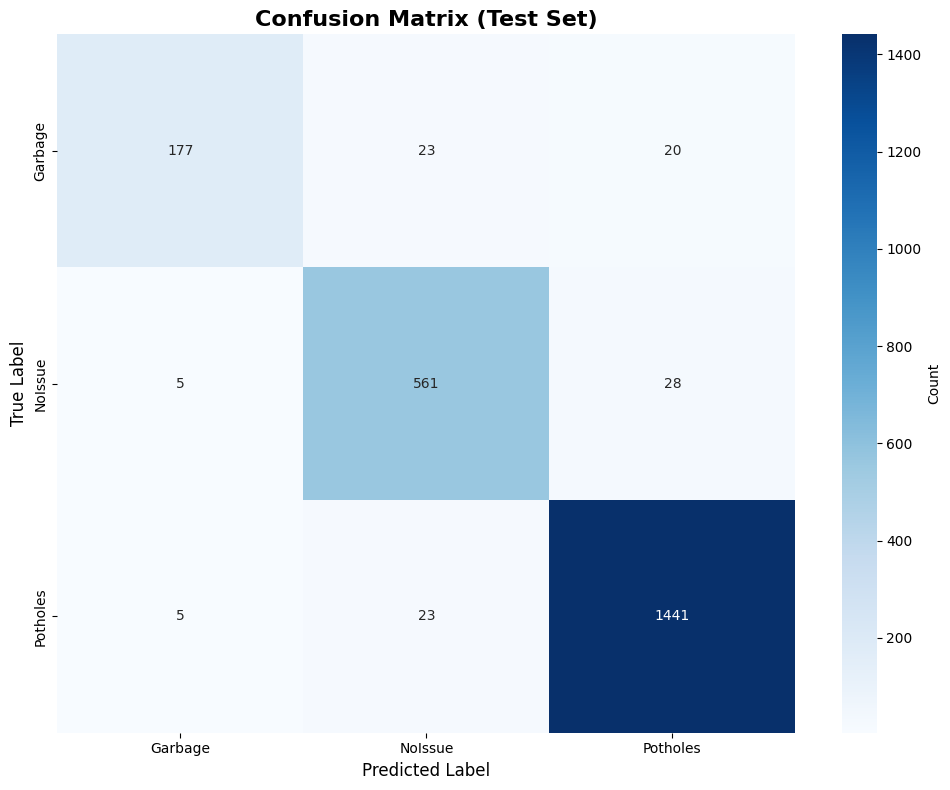


Per-Class Accuracy:
  Garbage: 80.45%
  NoIssue: 94.44%
  Potholes: 98.09%


In [13]:
print("\n" + "="*50)
print("GENERATING PREDICTIONS ON TEST SET")
print("="*50 + "\n")

# Generate predictions on test set
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
y_pred = np.argmax(predictions, axis=1)  # Get class with highest probability
y_true = test_generator.classes

# Get class names
class_names = list(train_generator.class_indices.keys())

# Classification report
print("\n" + "="*50)
print("CLASSIFICATION REPORT (TEST SET)")
print("="*50)
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix (Test Set)', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Per-class accuracy
print("\nPer-Class Accuracy:")
for i, class_name in enumerate(class_names):
    class_mask = y_true == i
    class_acc = (y_pred[class_mask] == y_true[class_mask]).sum() / class_mask.sum()
    print(f"  {class_name}: {class_acc*100:.2f}%")

In [14]:
SAVE_DIR = "/kaggle/working"
os.makedirs(SAVE_DIR, exist_ok=True)

model.save(f"{SAVE_DIR}/pothole_garbage_classifier.h5")
model.save(f"{SAVE_DIR}/pothole_garbage_classifier.keras")

class_info = {
    'class_names': class_names,
    'class_indices': train_generator.class_indices,
    'num_classes': len(class_names),
    'img_size': IMG_SIZE
}

with open(f"{SAVE_DIR}/class_info.json", "w") as f:
    json.dump(class_info, f, indent=4)

print("✓ Model and metadata saved to /kaggle/working")

✓ Model and metadata saved to /kaggle/working


In [ ]:
def predict_image(img_path, show_plot=True):
    """
    Predict class of a single image
    
    Args:
        img_path: Path to the image file
        show_plot: Whether to display the image with prediction
    
    Returns:
        tuple: (class_name, confidence, all_probabilities)
    """
    # Load and preprocess image
    img = keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    
    # Make prediction
    predictions = model.predict(img_array, verbose=0)[0]
    class_idx = np.argmax(predictions)
    class_name = class_names[class_idx]
    confidence = predictions[class_idx]
    
    # Display result
    if show_plot:
        plt.figure(figsize=(10, 6))
        
        # Image subplot
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title(f'Prediction: {class_name.upper()}\nConfidence: {confidence*100:.2f}%', 
                  fontsize=12, fontweight='bold')
        plt.axis('off')
        
        # Probability bar chart
        plt.subplot(1, 2, 2)
        colors = ['green' if i == class_idx else 'gray' for i in range(len(class_names))]
        plt.barh(class_names, predictions * 100, color=colors)
        plt.xlabel('Confidence (%)', fontsize=10)
        plt.title('Class Probabilities', fontsize=12, fontweight='bold')
        plt.xlim(0, 100)
        
        plt.tight_layout()
        plt.show()
    
    return class_name, confidence, predictions

print("✓ Prediction function defined")
print("\nUsage example:")
print("  predict_image('/path/to/image.jpg')")
print("\nReturns: (class_name, confidence, all_probabilities)")



In [ ]:
print("\n" + "="*50)
print("SAMPLE PREDICTIONS ON TEST DATA")
print("="*50 + "\n")

test_generator.reset()
x_batch, y_batch = next(test_generator)
predictions_batch = model.predict(x_batch, verbose=0)

plt.figure(figsize=(15, 10))
for i in range(min(12, len(x_batch))):
    plt.subplot(3, 4, i + 1)
    plt.imshow(x_batch[i])
    
    true_class_idx = np.argmax(y_batch[i])
    pred_class_idx = np.argmax(predictions_batch[i])
    
    true_class = class_names[true_class_idx]
    pred_class = class_names[pred_class_idx]
    confidence = predictions_batch[i][pred_class_idx]
    
    # Color code: green if correct, red if wrong
    color = 'green' if true_class == pred_class else 'red'
    
    plt.title(f'True: {true_class}\nPred: {pred_class} ({confidence*100:.1f}%)', 
              fontsize=9, color=color, fontweight='bold')
    plt.axis('off')

plt.suptitle('Sample Predictions on Test Set (Green=Correct, Red=Incorrect)', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("ALL BLOCKS COMPLETED SUCCESSFULLY!")
print("="*50)
print(f"\nFinal Results Summary:")
print(f"  Classes: {class_names}")
print(f"  Test Accuracy: {test_acc*100:.2f}%")
print(f"  Model saved as: pothole_garbage_classifier.h5")

In [ ]:
print(f"For i1 we got {predict_for_single_image( '/kaggle/input/helpppp/helppp/i1.png')}")
print(f"For i11 we got {predict_for_single_image( '/kaggle/input/helpppp/helppp/i11.jpeg')}")
print(f"For i2 we got {predict_for_single_image( '/kaggle/input/helpppp/helppp/i2.png')}")
print(f"For i3 we got {predict_for_single_image( '/kaggle/input/helpppp/helppp/i3.png')}")
print(f"For n1 we got {predict_for_single_image( '/kaggle/input/helpppp/helppp/n1.jpg')}")
print(f"For n2 we got {predict_for_single_image( '/kaggle/input/helpppp/helppp/n2.jpg')}")
print(f"For n3 we got {predict_for_single_image( '/kaggle/input/helpppp/helppp/n3.png')}")
print(f"For n4 we got {predict_for_single_image( '/kaggle/input/helpppp/helppp/n4.jpeg')}")
print(f"For boomer we got {predict_for_single_image( '/kaggle/input/helpppp/helppp/n4.jpeg')}")